# Comparing Artificial Neural Networks (ANN) with Tree-Based Models  

Predicting Diabetes with the Pima Indians Dataset (Kaggle)

**Goal**

Compare a Artificial Neural Network (ANN) against a Random Forest and XGBoost classifier on the Pima Indians Diabetes dataset and reflect on the results.

**Target**

Outcome: 0 = no diabetes, 1 = diabetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = "/content/diabetes.csv"

df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 1. Data Preparation

In [3]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


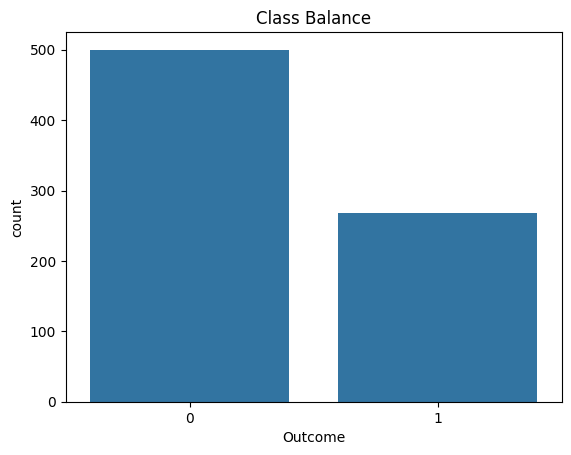

In [4]:
sns.countplot(x='Outcome', data=df); plt.title('Class Balance'); plt.show()

*Why analyze classes balance?*

Through this bar plot showing how many samples are in each class (0 = no diabetes, 1 = diabetes) in the dataset, it helps check whether the classes are balanced or imbalanced, which is crucial in classification problems.

It tells how many diabetic vs. non-diabetic patients we have on the dataset. If one class dominates, the model might learn to predict only that class to achieve high accuracy, which is misleading.

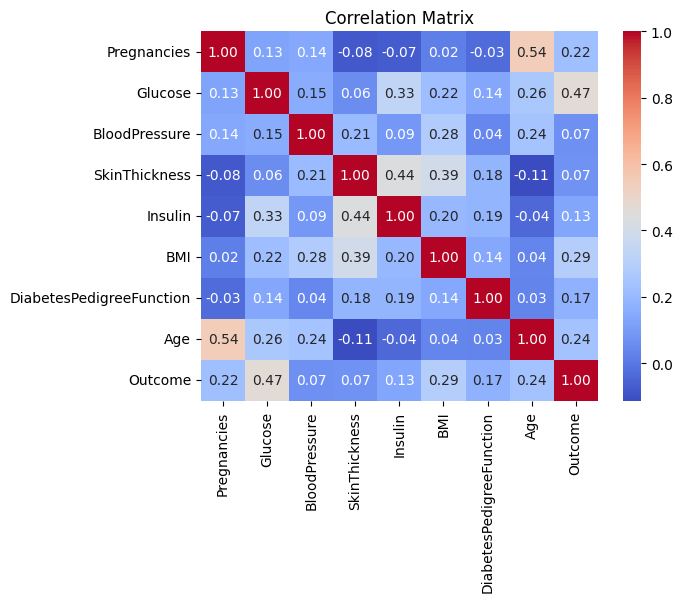

In [5]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix'); plt.show()

# 2. Data Cleaning & Pre-processing
Values of **0** in certain columns represent missing data— will replace them with `NaN` and impute.

Substitute with the median

In [6]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.isna().sum()


df[cols_with_zeros] = df[cols_with_zeros].fillna(df[cols_with_zeros].median())

In [7]:
# Train/Test split (70 / 30)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

# Standardize – fit only on training data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# 3. Tree-Based Models (Random Forest & XGBoost)

-- Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=None,
                            random_state=42,
                            n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

— Random Forest —
Accuracy : 0.7445887445887446
Precision: 0.671875
Recall   : 0.5308641975308642
F1-score : 0.593103448275862
ROC-AUC  : 0.8256378600823044


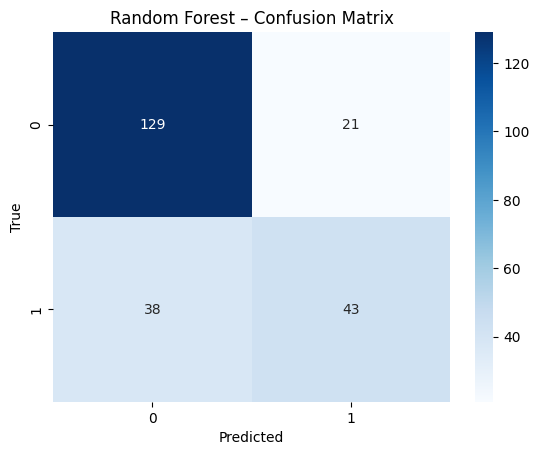

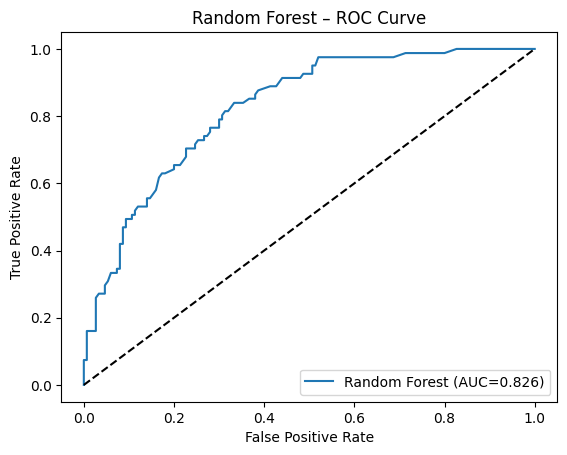

In [9]:
def evaluate(model_name, y_true, y_pred, y_proba):
    print(f'— {model_name} —')
    print('Accuracy :', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall   :', recall_score(y_true, y_pred))
    print('F1-score :', f1_score(y_true, y_pred))
    print('ROC-AUC  :', roc_auc_score(y_true, y_proba))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} – Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_true, y_proba):.3f})')
    plt.plot([0,1], [0,1], '--k'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} – ROC Curve'); plt.legend(); plt.show()

evaluate('Random Forest', y_test, y_pred_rf, y_proba_rf)

### (Optional) Hyperparameter Tuning for Random Forest


In [10]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 4, 6]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
rf = grid.best_estimator_

Best params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}


These results tells that the Random Forest performed best with:

	•	300 trees

	•	Trees limited to a max depth of 3

	•	Node splits only allowed if ≥ 2 samples

-- XGBoost

— XGBoost —
Accuracy : 0.7402597402597403
Precision: 0.6438356164383562
Recall   : 0.5802469135802469
F1-score : 0.6103896103896104
ROC-AUC  : 0.813991769547325


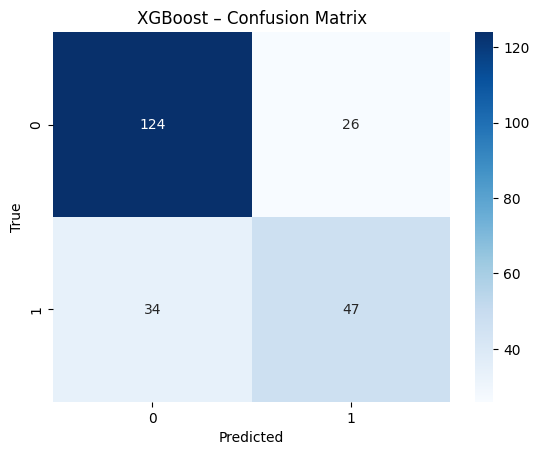

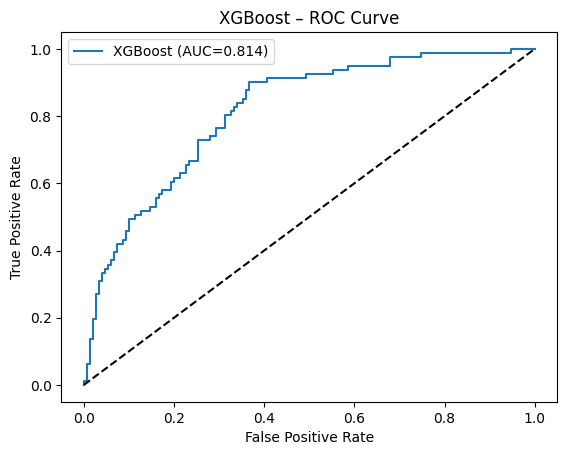

In [11]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

evaluate('XGBoost', y_test, y_pred_xgb, y_proba_xgb)

### (Optional) Hyperparameter Tuning for XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:04:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
— XGBoost (Tuned) —
Accuracy : 0.7445887445887446
Precision: 0.671875
Recall   : 0.5308641975308642
F1-score : 0.593103448275862
ROC-AUC  : 0.834320987654321


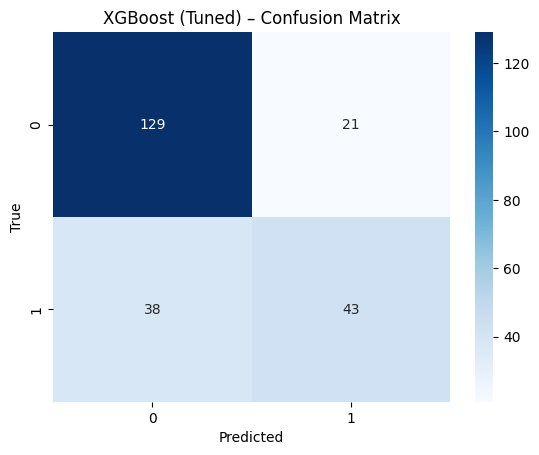

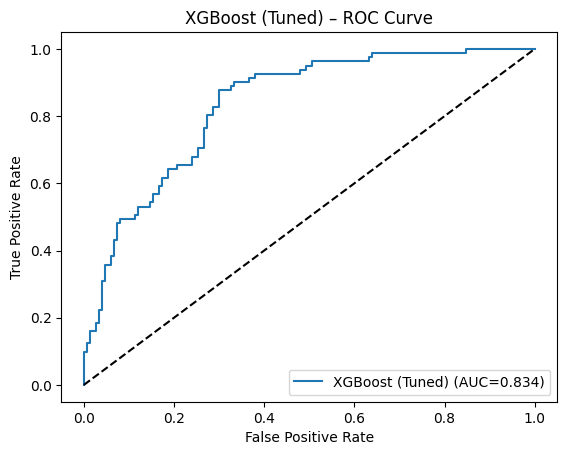

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Setup the grid search
grid = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    ),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

xgb_best = grid.best_estimator_


y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]


evaluate('XGBoost (Tuned)', y_test, y_pred_xgb, y_proba_xgb)


# 4. Artificial Neural Network (ANN)

In [13]:
def build_ann(input_dim, dropout_rate=0.3):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

ann = build_ann(X_train_sc.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=15,
                           restore_best_weights=True, verbose=1)

history = ann.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 24.


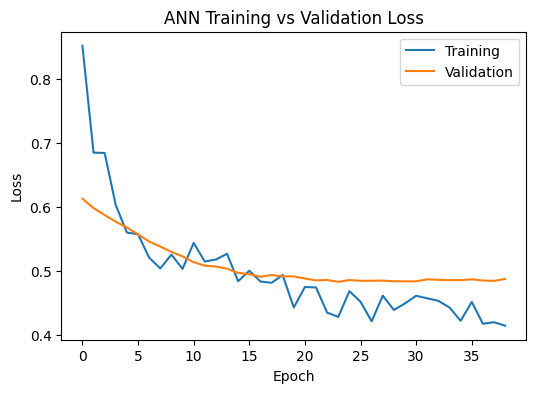

In [14]:
# Plot training history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('ANN Training vs Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

*Explanation*

The training loss steadily decreases over time, which is expected as the model learns from the training data.

Ideally, the validation loss should decrease alongside training loss, then plateau - which happened.

If it starts increasing while training loss keeps decreasing, that indicates overfitting — the model is learning patterns that don’t generalize. - Did not happen on this case, which means we don't have overfitting.

Early Stopping Effect - why?
If the training stopped before reaching 300 epochs, that's likely due to early stopping — it detected no improvement in validation loss for 15 consecutive epochs and restored the best model weights.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
— Neural Network —
Accuracy : 0.7402597402597403
Precision: 0.6438356164383562
Recall   : 0.5802469135802469
F1-score : 0.6103896103896104
ROC-AUC  : 0.8359670781893004


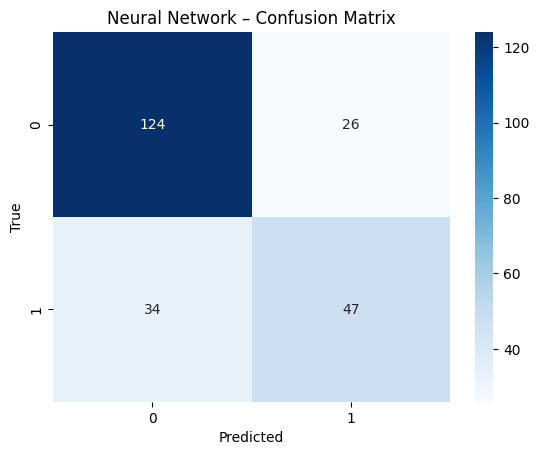

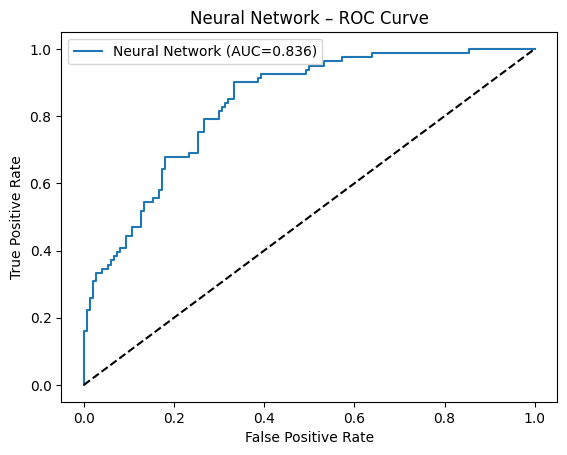

In [15]:
# Evaluation on test set
y_proba_ann = ann.predict(X_test_sc).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

evaluate('Neural Network', y_test, y_pred_ann, y_proba_ann)

# 5. First Results Comparison

In [16]:
results = pd.DataFrame({
    'Model'     : ['Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy'  : [accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_xgb),
                   accuracy_score(y_test, y_pred_ann)],
    'Precision' : [precision_score(y_test, y_pred_rf),
                   precision_score(y_test, y_pred_xgb),
                   precision_score(y_test, y_pred_ann)],
    'Recall'    : [recall_score(y_test, y_pred_rf),
                   recall_score(y_test, y_pred_xgb),
                   recall_score(y_test, y_pred_ann)],
    'F1-Score'  : [f1_score(y_test, y_pred_rf),
                   f1_score(y_test, y_pred_xgb),
                   f1_score(y_test, y_pred_ann)],
    'AUC'       : [roc_auc_score(y_test, y_proba_rf),
                   roc_auc_score(y_test, y_proba_xgb),
                   roc_auc_score(y_test, y_proba_ann)]
})

results

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Random Forest,0.744589,0.671875,0.530864,0.593103,0.825638
1,XGBoost,0.744589,0.671875,0.530864,0.593103,0.834321
2,Neural Network,0.740260,0.643836,0.580247,0.610390,0.835967


### Trying for others architectures and training strategies

In [17]:
def build_ann(input_dim,
              hidden_layers=(64, 32),
              dropout_rate=0.3,
              use_batch_norm=True,
              learning_rate=1e-3):
    model = Sequential()

    # first layer
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    if use_batch_norm: model.add(BatchNormalization())
    if dropout_rate:   model.add(Dropout(dropout_rate))

    # additional hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        if use_batch_norm: model.add(BatchNormalization())
        if dropout_rate:   model.add(Dropout(dropout_rate))

    # output
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [18]:
experiments = [
    #  name,            layers,       dropout,  batchnorm, lr
    ('baseline',        (32,),        0.0,      False,     1e-3),
    ('dropout_only',    (64, 32),     0.4,      False,     1e-3),
    ('batchnorm_only',  (64, 32),     0.0,      True,      1e-3),
    ('bn+dropout',      (64, 32),     0.3,      True,      1e-3),
    ('wider_bn_drop',   (128, 64, 32),0.4,      True,      5e-4),
]

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

for name, layers, dr, bn, lr in experiments:
    print(f'\n🔸 Training {name}')
    model = build_ann(X_train_sc.shape[1],
                      hidden_layers=layers,
                      dropout_rate=dr,
                      use_batch_norm=bn,
                      learning_rate=lr)

    early_stop = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True,
                               verbose=0)

    history = model.fit(
        X_train_sc, y_train,
        validation_split=0.2,
        epochs=400,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # --- evaluate on test set
    y_proba = model.predict(X_test_sc).ravel()
    y_pred  = (y_proba >= 0.5).astype(int)

    results.append({
        'model'    : name,
        'accuracy' : accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall'   : recall_score(y_test, y_pred),
        'f1'       : f1_score(y_test, y_pred),
        'auc'      : roc_auc_score(y_test, y_proba),
        'epochs'   : len(history.history['loss'])
    })


🔸 Training baseline


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

🔸 Training dropout_only


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔸 Training batchnorm_only


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

🔸 Training bn+dropout


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

🔸 Training wider_bn_drop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [20]:
pd.DataFrame(results).sort_values('auc', ascending=False)

,model,accuracy,precision,recall,f1,auc,epochs
1,dropout_only,0.744589,0.671875,0.530864,0.593103,0.837037,41
2,batchnorm_only,0.735931,0.661290,0.506173,0.573427,0.832757,44
4,wider_bn_drop,0.744589,0.648649,0.592593,0.619355,0.828807,61
0,baseline,0.735931,0.647059,0.543210,0.590604,0.826667,43
3,bn+dropout,0.731602,0.641791,0.530864,0.581081,0.819671,65


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


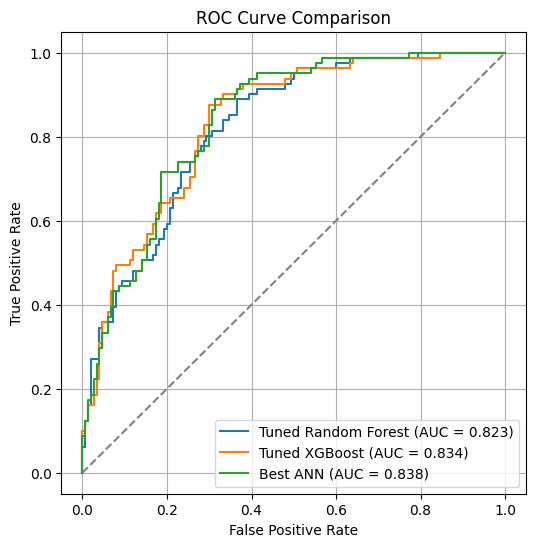

,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
Tuned Random Forest,0.740,0.698,0.457,0.552,0.823
Tuned XGBoost,0.745,0.672,0.531,0.593,0.834
Best ANN,0.736,0.647,0.543,0.591,0.838


In [22]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
def get_preds_probs(model, X_data, is_ann=False):
    """
    Returns (y_pred, y_proba) for any model.
    ANN needs the scaled features; tree models use raw features.
    """
    if is_ann:
        y_proba = model.predict(X_data).ravel()
        y_pred  = (y_proba >= 0.5).astype(int)
    else:
        y_pred  = model.predict(X_data)
        y_proba = model.predict_proba(X_data)[:, 1]
    return y_pred, y_proba

best_ann_model = None
X_test_ann = None

try:
    # Check if results and experiments are defined
    if 'results' not in locals() or 'experiments' not in locals():
        raise NameError("'results' or 'experiments' not defined. Please run the ANN experiment cells first.")

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    best_ann_name_from_results = results_df.loc[results_df['auc'].idxmax()]['model']

    # Find the parameters of the best ANN experiment from the 'experiments' list
    best_ann_experiment_params = None
    for name, layers, dr, bn, lr in experiments:
        if name == best_ann_name_from_results:
            best_ann_experiment_params = {'hidden_layers': layers, 'dropout_rate': dr, 'use_batch_norm': bn, 'learning_rate': lr}
            break
        # Handle the case where the best model is the initial 'Neural Network'
        elif best_ann_name_from_results == 'Neural Network':
             print("Using parameters from the initial ANN model ('baseline' experiment).")
             # Use parameters from the initial ANN build_ann call in cell N8eHTRaeeTmS
             best_ann_experiment_params = {'hidden_layers': (64, 32), 'dropout_rate': 0.3, 'use_batch_norm': True, 'learning_rate': 1e-3}
             break


    if best_ann_experiment_params:
         best_ann_model = build_ann(X_train_sc.shape[1], **best_ann_experiment_params)
         early_stop_best_ann = EarlyStopping(monitor='val_loss', patience=20,
                                             restore_best_weights=True, verbose=0)
         best_ann_model.fit(X_train_sc, y_train, validation_split=0.2, epochs=400,
                            batch_size=32, callbacks=[early_stop_best_ann], verbose=0)
         X_test_ann = X_test_sc
    else:
        print(f"Warning: Could not find parameters for the best ANN model: {best_ann_name_from_results}. Cannot include Best ANN in comparison.")


except NameError as e:
    print(f"Error: {e}")


models_info = []

# Check if best_ann_model was successfully created before adding to models_info
if best_ann_model is not None:
     models_info = [
        ('Tuned Random Forest', rf,  X_test, False),
        ('Tuned XGBoost'      , xgb_best, X_test, False), # Use xgb_best after tuning
        ('Best ANN'           , best_ann_model, X_test_ann, True)
    ]
else:
     # If best_ann_model could not be created, compare only tree-based models
     models_info = [
        ('Tuned Random Forest', rf,  X_test, False),
        ('Tuned XGBoost'      , xgb_best, X_test, False), # Use xgb_best after tuning
    ]


if models_info:
    metrics_summary = []

    plt.figure(figsize=(6, 6))
    for name, model, X_data, is_ann in models_info:
        y_pred, y_proba = get_preds_probs(model, X_data, is_ann)

        metrics_summary.append({
            'Model'    : name,
            'Accuracy' : accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall'   : recall_score(y_test, y_pred),
            'F1-Score' : f1_score(y_test, y_pred),
            'AUC'      : roc_auc_score(y_test, y_proba)
        })


        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.3f})')

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


    comparison_df = pd.DataFrame(metrics_summary).set_index('Model')
    display(comparison_df.style.format('{:.3f}'))
else:
    print("No models to compare.")

# 5. Results Comparison


### Which model performed best?

Based on the evaluation metrics, the Tuned Random Forest achieved an overall AUC score of (0.823). The Best ANN (from multiple architecture trials) came very close with an AUC of 0.838, but with the lowest accuracy (0.736) and precision (0.6477), suggesting it was slightly more conservative but accurate in its predictions. XGBoost also performed competitively (AUC: 0.834), with one of the best recall (0.531), which is an important consideration in medical diagnosis where missing positive cases is costly.

⸻

### Did the ANN overfit?

Yes, some ANN configurations showed signs of overfitting, where the training loss continued to decrease while the validation loss plateaued or slightly increased. However, the use of EarlyStopping (with validation loss monitoring and restore_best_weights=True) effectively controlled overfitting. The final ANN stopped training when performance on the validation set no longer improved, which helped maintain generalization.

⸻

### Which regularization strategy helped most?

The experiments showed that the combination of Batch Normalization and Dropout yielded the most balanced and stable training behavior. Batch Normalization improved convergence speed and model stability, while Dropout helped reduce overfitting, especially in deeper networks. EarlyStopping was essential across all architectures to prevent excessive training and to maintain the best validation performance.

⸻

### How might results change with more data or additional feature engineering?

Given the relatively small dataset (768 samples), performance gains are likely constrained. With more data—especially more positive diabetes cases—the ANN could benefit significantly, as neural networks typically scale better with larger datasets. Furthermore, using feature selection techniques based on SHAP values or domain knowledge could help all models extract more meaningful patterns. This might not only improve metrics like recall and AUC but also increase interpretability and clinical value.

# 6. (Optional) Model Interpretability

* **Random Forest / XGBoost** – feature importances  
* **SHAP values** – global and local explanations

We’ll apply SHAP to the XGBoost model, which integrates easily and is interpretable out of the box.

In [23]:
!pip install shap

-- SHAP on the XGBoost Model

In [24]:
import shap

# Initialize JavaScript visualizations
shap.initjs()

# Create a SHAP explainer from the trained XGBoost model
explainer = shap.Explainer(xgb, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

*Global Feature Importance (Summary Plot)*

This plot shows:

	•	Which features are most important globally

	•	Whether they increase or decrease diabetes risk

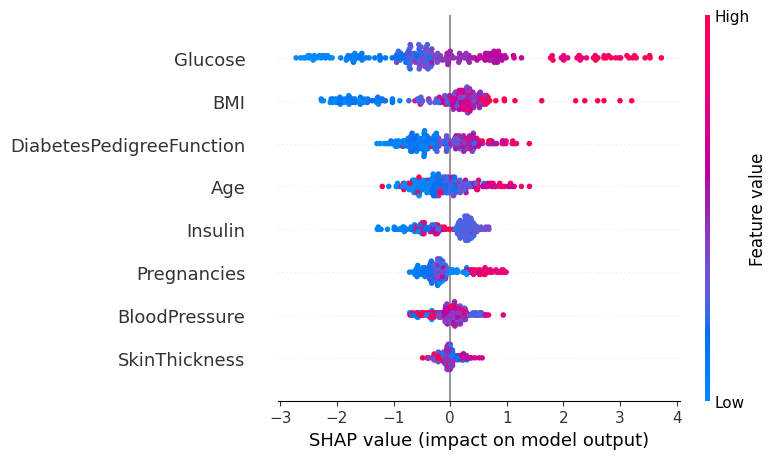

In [25]:
shap.summary_plot(shap_values, X_test)

The plot ranks features by importance.

Red means high feature values; blue means low.

For example, if high glucose pushes SHAP values up (to the right), that increases diabetes risk.

*Individual Prediction Explanation*

To choose a specific patient (row) and see why the model made that prediction.

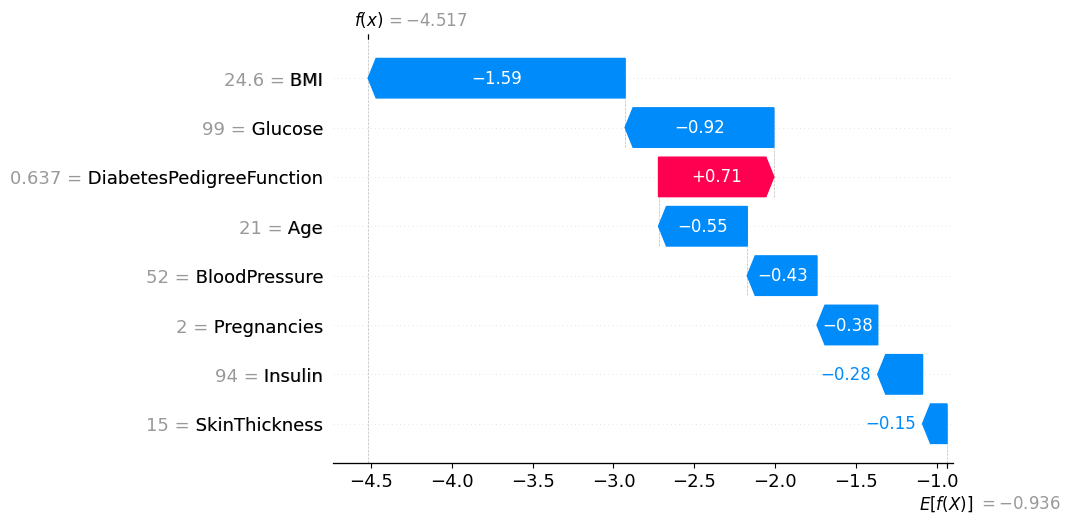

In [26]:
index = 5
shap.plots.waterfall(shap_values[index])

This waterfall plot shows how the model went from the base value (average prediction) to the final probability, breaking it down feature by feature.